In [4]:
import deepdish as dd
import os
import numpy as np
import pylab as plt
import seaborn as sns
import h5py
import pandas as pd
from astropy.cosmology import Planck18 as cosmo

In [5]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import detectors, detector_psds

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=10, method='network', return_detected_dict=False):
    SNR_keys = [key for key in data_dict.keys() if 'SNR' in key]
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        dict_key = key.split('SNR_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0)]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [8]:
test_data_local = dd.io.load('../output_data/Test_data/1_day_prec_z_10_local_SNR_data.h5')['Optimal_SNR']

In [9]:
netw_labels = {'CE4020ET123':'CE4020, ET123',
               'CE40LIAsharpET123':'CE40, LI A#, ET123',
               'LHI_all_ASharp':'LHI @ A#',
               'LHV_design':'LHV design',
               'LH_APlus_V_design': 'LH @ A+, V @ design'}

In [10]:
def bin_style(hist_data):
    if len(hist_data)>100:
        bs = 'sqrt'
    else:
        if len(hist_data)>50:
            bs = 'auto'
        else:
            bs = len(hist_data)//3
            if bs==0:
                bs=1
    return(bs)

In [11]:
def plot_efficiency_curve(selected_data, total_data, bins='sqrt', **kwargs):
    ns_sel, bins_sel = np.histogram(selected_data, bins=bins)
    ns_tot, bins_tot = np.histogram(total_data, bins=bins_sel)
    if not np.all(bins_sel == bins_tot):
        raise ValueError("Bins are not equal! Something went wrong.")
    eff_samples = ns_sel/ns_tot
    #plt.bar(bins_sel[:-1], eff_samples, np.diff(bins_sel), **kwargs)
    
    # Using plt.step to create a step-like plot
    line = plt.stairs(eff_samples, bins_sel, **kwargs)
    return(eff_samples, bins_sel)

## BBH

In [12]:
data_dir_bbh = '../output_data/BBH/'

In [13]:
snr_data_bbh = {}
config_bbh = {}
for data_file in list(os.walk(data_dir_bbh))[0][2]:
    key = data_file.split('_PLP_')[0]
    bbh_data = dd.io.load(os.path.join(data_dir_bbh, data_file))
    snr_data_bbh[key] = bbh_data['Optimal_SNR']
    snr_data_bbh[key]['comoving_distance'] = cosmo.comoving_distance(snr_data_bbh[key]['redshift'])
    config_bbh[key] = bbh_data['config']

In [14]:
detected_bbh = {'all':{}, 'network':{}}
for key in snr_data_bbh.keys():
    detected_bbh['all'][key] = get_detected_SNRs(snr_data_bbh[key], method='all')
    detected_bbh['network'][key] = get_detected_SNRs(snr_data_bbh[key], method='network')

In [50]:
snr_data_bbh['CE4020ET123']

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,spin1_a,spin2_a,chi_eff,chi_p,mchirp,...,trigger_time,polarization,ra,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,SNR_network,comoving_distance
0,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.195337,0.827847,0.052656,0.366349,10.704580,...,1.893024e+09,1.537248,1.766131,33.252183,8.955096,18.136734,18.280348,17.828498,46.549641,4161.129836
1,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.550430,0.889245,0.018857,0.534263,18.516904,...,1.893025e+09,1.225743,3.404836,52.835775,27.140730,7.002552,7.552237,2.235278,60.326668,4305.764120
2,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.756110,0.265047,-0.208923,0.647026,33.804928,...,1.893025e+09,0.867893,2.895788,14.137828,8.806848,9.422183,8.717016,5.484750,21.732122,6425.181094
3,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.222736,0.265040,0.095232,0.175412,12.569101,...,1.893025e+09,1.304756,0.808838,126.126999,70.078252,30.883533,36.871920,29.191155,154.869093,1760.527095
4,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.865201,0.145375,-0.054473,0.863849,11.187927,...,1.893025e+09,2.755326,1.639353,17.873575,9.476213,8.982659,9.103226,9.051581,25.588109,4780.829748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.110024,0.647354,0.171299,0.456569,14.014621,...,1.895691e+09,1.958387,4.873905,76.182986,21.156287,25.358306,26.459958,26.493519,91.085210,3865.611805
9564,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.968920,0.142598,-0.236310,0.915228,15.374073,...,1.895691e+09,2.799009,2.640505,21.698629,9.387621,4.969945,5.747137,4.713289,25.276530,5744.632679
9565,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.825221,0.025724,0.462867,0.371363,28.636023,...,1.895691e+09,0.094646,0.674527,66.685490,42.874328,21.516811,13.128492,25.216336,86.927307,3736.848888
9566,CosmicExplorerP1600143,CE20,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,EinsteinTelescopeP1600143,0.315108,0.433484,0.158263,0.313394,25.549983,...,1.895691e+09,2.269243,1.198367,33.239385,18.337503,29.289091,29.169483,29.377468,63.347186,5187.479295


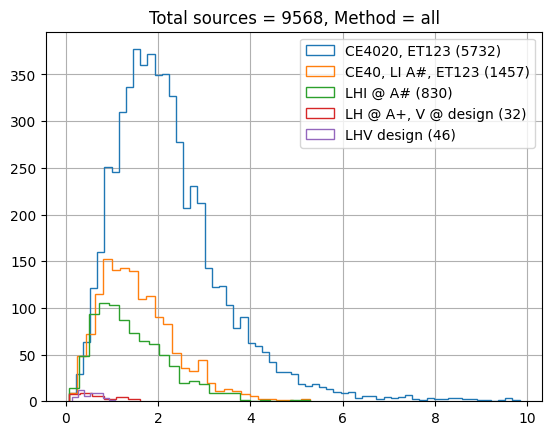

In [15]:
for key in detected_bbh['all'].keys():
    bbh_data = detected_bbh['all'][key]
    plt.hist(bbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bbh_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh["CE4020ET123"]["mass1"])}, Method = all')
plt.grid()

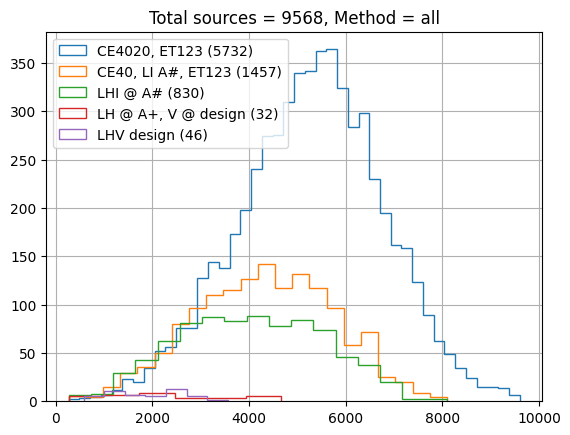

In [41]:
for key in detected_bbh['all'].keys():
    bbh_data = detected_bbh['all'][key]
    plt.hist(bbh_data['comoving_distance'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bbh_data["comoving_distance"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh["CE4020ET123"]["mass1"])}, Method = all')
plt.grid()

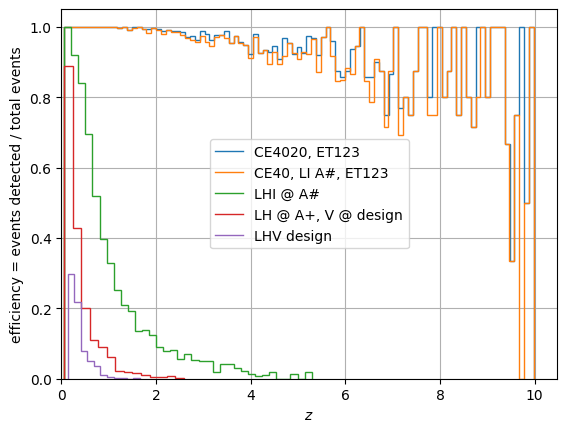

In [16]:
for netw in snr_data_bbh.keys():
    plot_efficiency_curve(detected_bbh['network'][netw]['redshift'], snr_data_bbh[netw]['redshift'], label=netw_labels[netw], zorder=2)
plt.legend(loc=10)
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid(zorder=0)

/tmp/ipykernel_42316/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


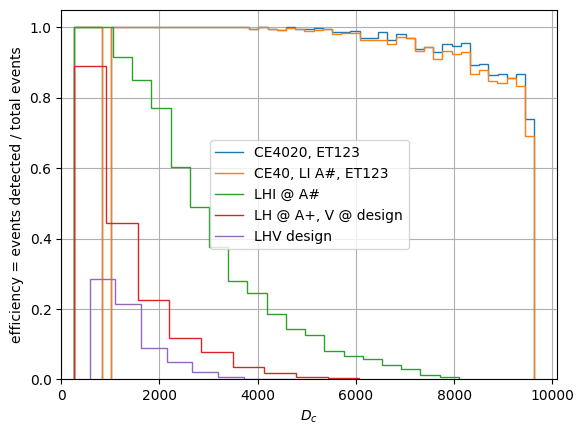

In [17]:
for netw in snr_data_bbh.keys():
    plot_efficiency_curve(detected_bbh['network'][netw]['comoving_distance'], 
                          snr_data_bbh[netw]['comoving_distance'], label=netw_labels[netw], 
                          zorder=2, bins='auto')
plt.legend(loc=10)
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$D_c$')
plt.ylabel('efficiency = events detected / total events')
plt.grid(zorder=0)

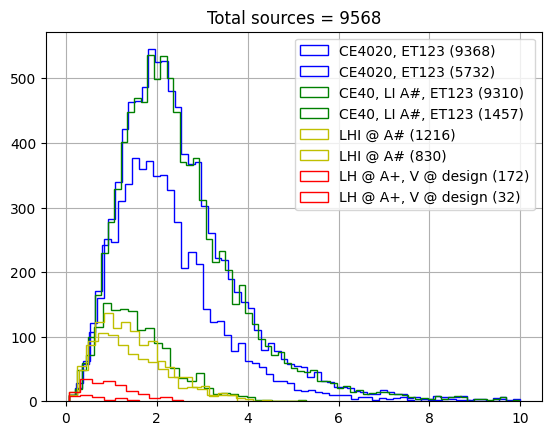

In [18]:
for key, colr in zip(detected_bbh['network'].keys(), ['b', 'g', 'y', 'r']):
    bbh_data = detected_bbh['network'][key]
    plt.hist(bbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bbh_data["redshift"])})', bins='auto', color=colr)
    bbh_data1 = detected_bbh['all'][key]
    plt.hist(bbh_data1['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bbh_data1["redshift"])})', bins='auto', ls='--', color=colr)
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh["CE4020ET123"]["mass1"])}')
plt.grid()

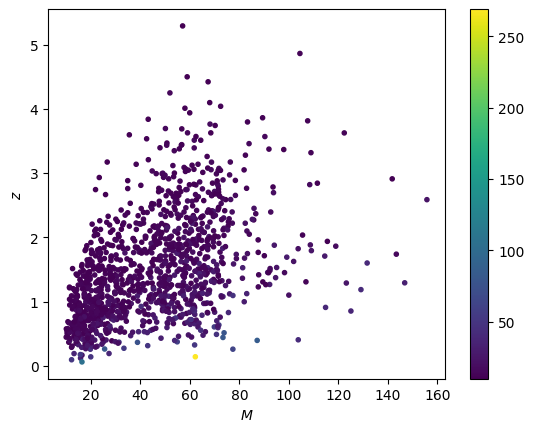

In [19]:
plt.scatter(detected_bbh['network']['LHI_all_ASharp']['srcmtotal'], 
            detected_bbh['network']['LHI_all_ASharp']['redshift'], 
            c=detected_bbh['network']['LHI_all_ASharp']['SNR_network'], marker='.')
plt.xlabel('$M$')
plt.ylabel('$z$')
plt.colorbar()

### Mass populations

In [20]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [21]:
detect_type = 'network'
mass_pops_bbh = {}

for m_range in ['<10', '10-30', '30-70', '>70']:
    mass_pops_bbh[m_range] = {}
    for pop, input_dfs_dict in zip(['detected', 'total'], [detected_bbh[detect_type], snr_data_bbh]):
        mass_pops_bbh[m_range][pop] = {}
        for netw in input_dfs_dict.keys():
            bool_arr = slice_mtotal_pop(input_dfs_dict[netw]['srcmtotal'], m_range)
            mass_pops_bbh[m_range][pop][netw] = input_dfs_dict[netw][bool_arr]

In [22]:
input_dfs_dict.keys()

dict_keys(['CE4020ET123', 'CE40LIAsharpET123', 'LHI_all_ASharp', 'LH_APlus_V_design', 'LHV_design'])

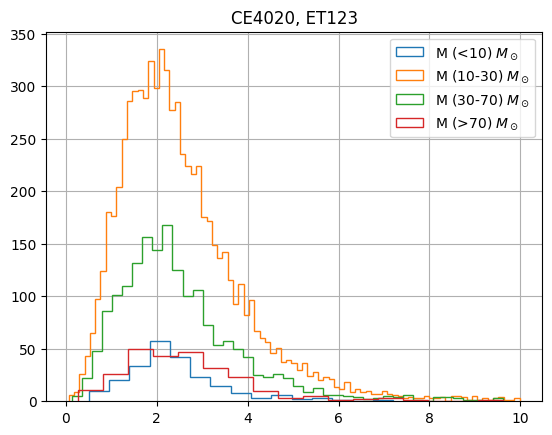

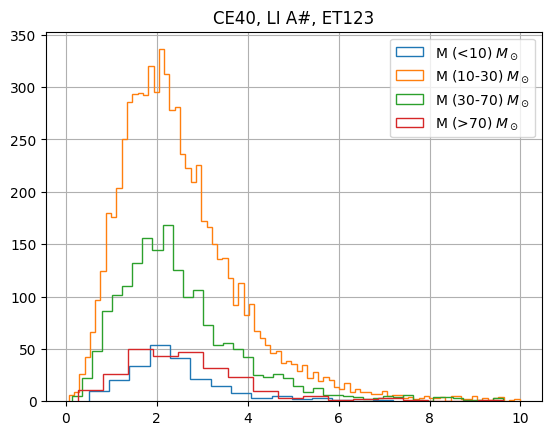

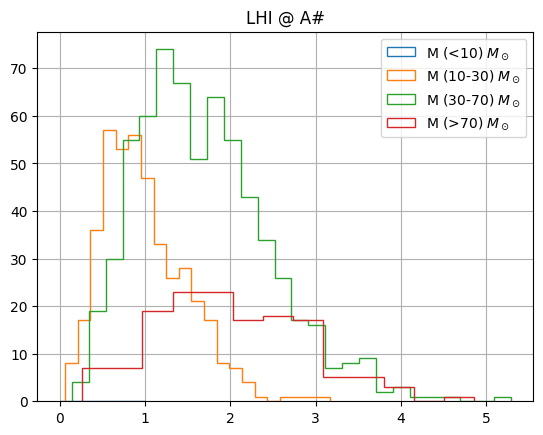

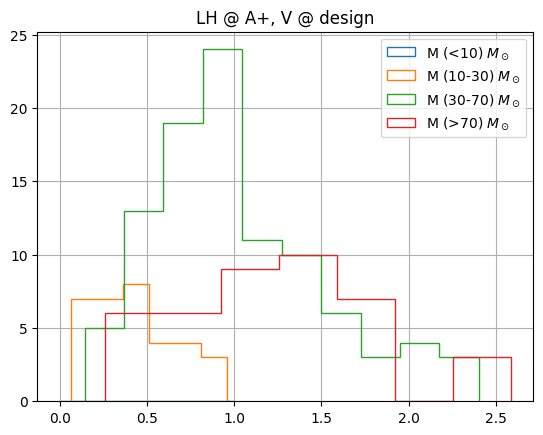

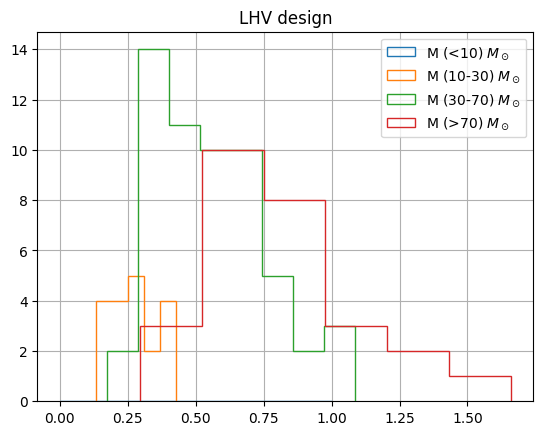

In [23]:
for netw in input_dfs_dict.keys():
    plt.figure()
    for m_range, color in zip(mass_pops_bbh.keys(), colors):
        hist_data = mass_pops_bbh[m_range]['detected'][netw]['redshift']
        plt.hist(hist_data, bins='sqrt', histtype=u'step', label='M ('+m_range+') $M_\odot$', color=color);
    plt.title(netw_labels[netw])
    plt.legend()
    plt.grid()

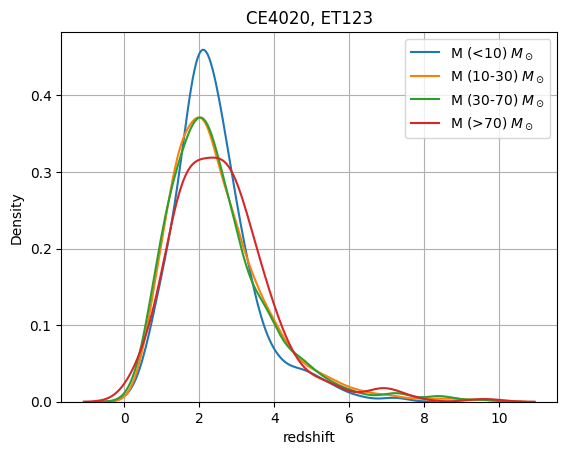

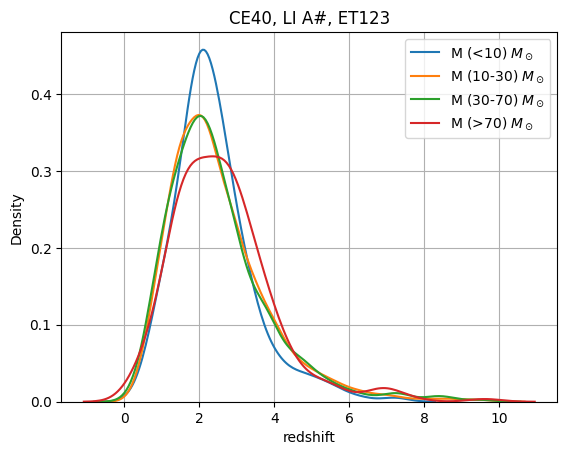

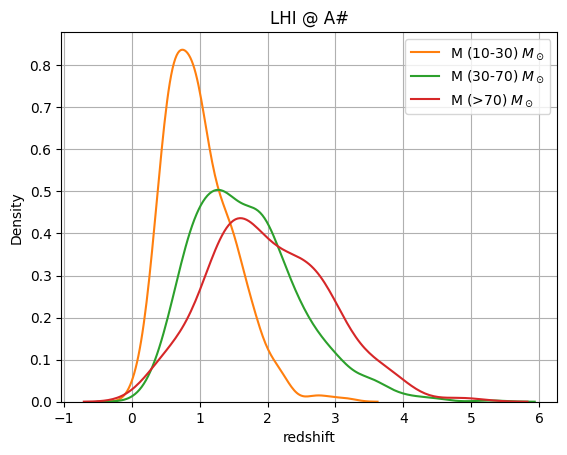

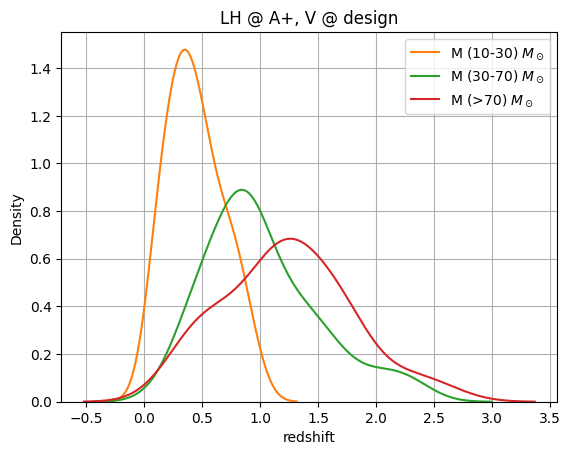

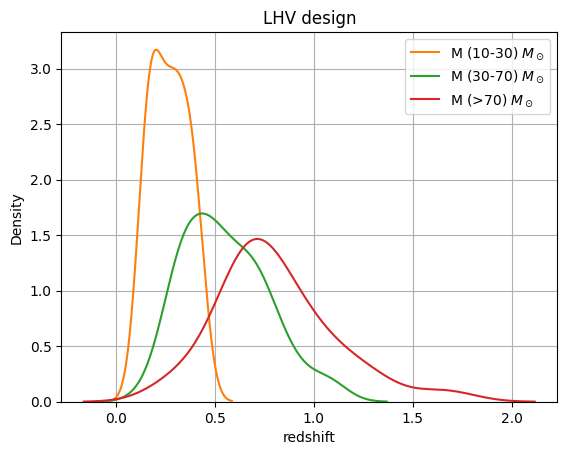

In [24]:
for netw in input_dfs_dict.keys():
    plt.figure()
    for m_range, color in zip(mass_pops_bbh.keys(), colors):
        hist_data = mass_pops_bbh[m_range]['detected'][netw]['redshift']
        sns.kdeplot(hist_data, label='M ('+m_range+') $M_\odot$', color=color);
    plt.title(netw_labels[netw])
    plt.legend()
    plt.grid()

Text(0.5, 1.0, '30 < M < 70')

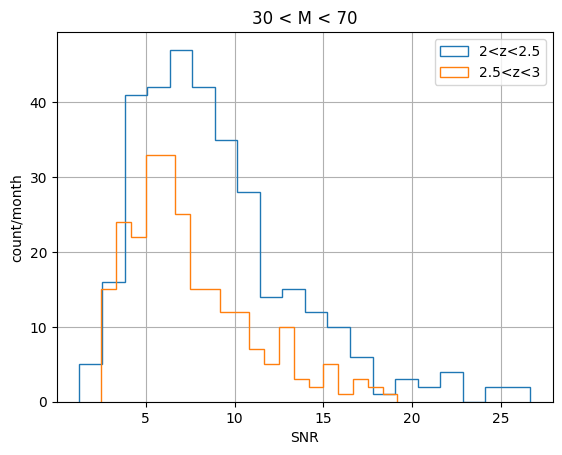

In [40]:
# This is first time we'll be seeing over the SFR peak with a few events which are detectable
plt.hist(mass_pops_bbh['30-70']['total']['LHI_all_ASharp']['SNR_network'][np.all((mass_pops_bbh['30-70']['total']['LHI_all_ASharp']['redshift'] < 2.5, 
                                                                      mass_pops_bbh['30-70']['total']['LHI_all_ASharp']['redshift'] > 2), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2<z<2.5');
plt.hist(mass_pops_bbh['30-70']['total']['LHI_all_ASharp']['SNR_network'][np.all((mass_pops_bbh['30-70']['total']['LHI_all_ASharp']['redshift'] < 3, 
                                                                      mass_pops_bbh['30-70']['total']['LHI_all_ASharp']['redshift'] > 2.5), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2.5<z<3');
plt.xlabel('SNR')
plt.grid()
plt.ylabel('count/month')
plt.legend()
plt.title('30 < M < 70')

/tmp/ipykernel_42316/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


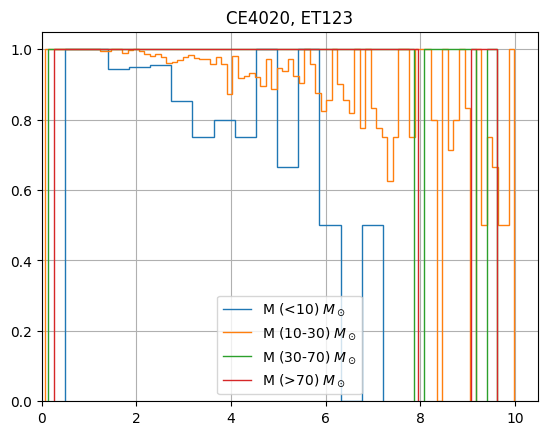

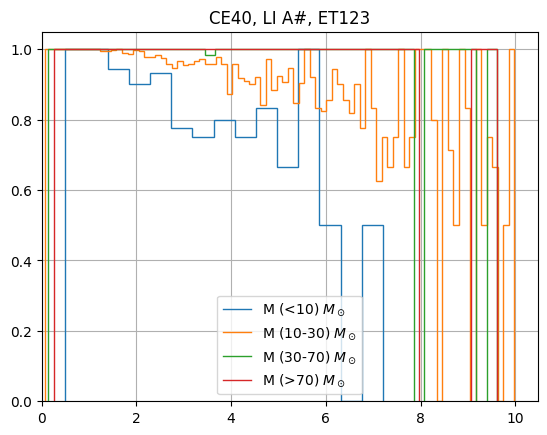

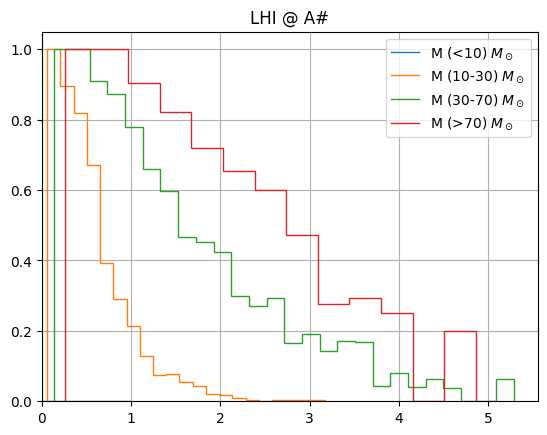

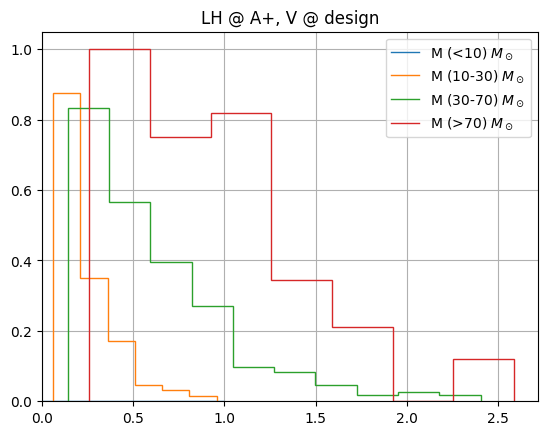

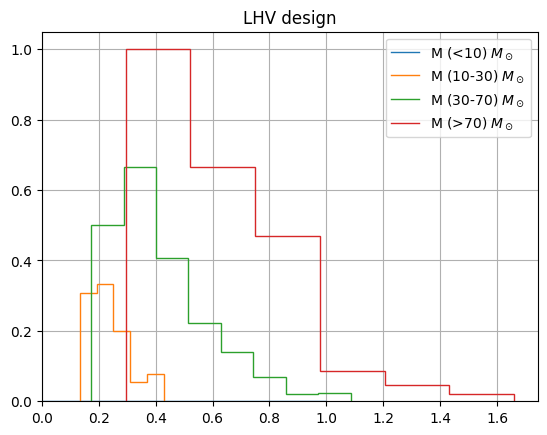

In [35]:
for netw in input_dfs_dict.keys():
    plt.figure()
    for m_range, color in zip(mass_pops_bbh.keys(), colors):
        hist_data_sel = mass_pops_bbh[m_range]['detected'][netw]['redshift']
        hist_data_tot = mass_pops_bbh[m_range]['total'][netw]['redshift']
        plot_efficiency_curve(hist_data_sel, hist_data_tot, bins='sqrt', label='M ('+m_range+') $M_\odot$', color=color, zorder=2);
    plt.title(netw_labels[netw])
    plt.legend()
    plt.xlim(0,)
    plt.grid()

## NSBH

In [27]:
data_dir_nsbh = '../output_data/NSBH/'

In [28]:
snr_data_nsbh = {}
config_nsbh = {}
for data_file in list(os.walk(data_dir_nsbh))[0][2]:
    key = data_file.split('_US_')[0]
    nsbh_data = dd.io.load(os.path.join(data_dir_nsbh, data_file))
    snr_data_nsbh[key] = nsbh_data['Optimal_SNR']
    snr_data_nsbh[key]['comoving_distance'] = cosmo.comoving_distance(snr_data_nsbh[key]['redshift'])
    config_nsbh[key] = nsbh_data['config']

In [29]:
detected_nsbh = {'all':{}, 'network':{}}
for key in snr_data_nsbh.keys():
    detected_nsbh['all'][key] = get_detected_SNRs(snr_data_nsbh[key], method='all')
    detected_nsbh['network'][key] = get_detected_SNRs(snr_data_nsbh[key], method='network')

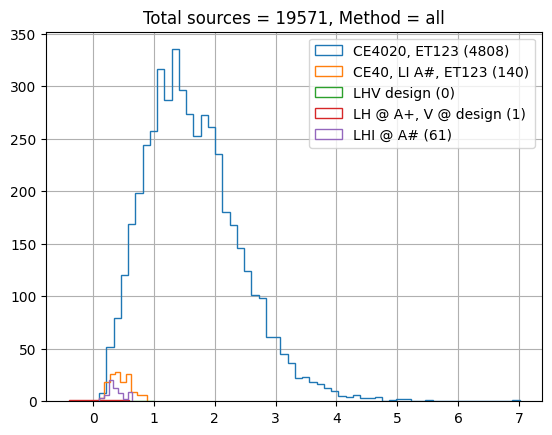

In [30]:
for key in detected_nsbh['all'].keys():
    nsbh_data = detected_nsbh['all'][key]
    plt.hist(nsbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(nsbh_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_nsbh["CE4020ET123"]["mass1"])}, Method = all')
plt.grid()

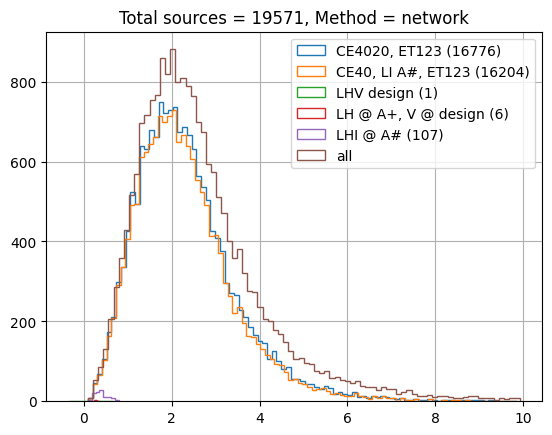

In [42]:
for key in detected_nsbh['network'].keys():
    nsbh_data = detected_nsbh['network'][key]
    plt.hist(nsbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(nsbh_data["redshift"])})', bins='auto')
plt.hist(snr_data_nsbh['CE4020ET123']['redshift'], histtype=u'step', label='all', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_nsbh["LHV_design"]["mass1"])}, Method = network')
plt.grid()

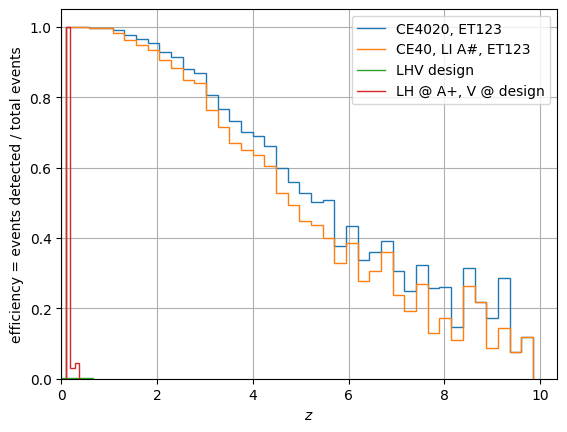

In [32]:
for netw, bns in zip(snr_data_nsbh.keys(), [40, 40, 'sqrt', 'sqrt']):
    vals = plot_efficiency_curve(detected_nsbh['network'][netw]['redshift'], snr_data_nsbh[netw]['redshift'], label=netw_labels[netw], bins=bns, zorder=2)
plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid()

## BNS

In [44]:
data_dir_bns = '../output_data/BNS/'

In [45]:
snr_data_bns = {}
config_bns = {}
for data_file in list(os.walk(data_dir_bns))[0][2]:
    key = data_file.split('_DG_')[0]
    bns_data = dd.io.load(os.path.join(data_dir_bns, data_file))
    snr_data_bns[key] = bns_data['Optimal_SNR']
    snr_data_bns[key]['comoving_distance'] = cosmo.comoving_distance(snr_data_bns[key]['redshift'])
    config_bns[key] = bns_data['config']

In [46]:
detected_bns = {'all':{}, 'network':{}}
for key in snr_data_bns.keys():
    detected_bns['all'][key] = get_detected_SNRs(snr_data_bns[key], method='all')
    detected_bns['network'][key] = get_detected_SNRs(snr_data_bns[key], method='network')

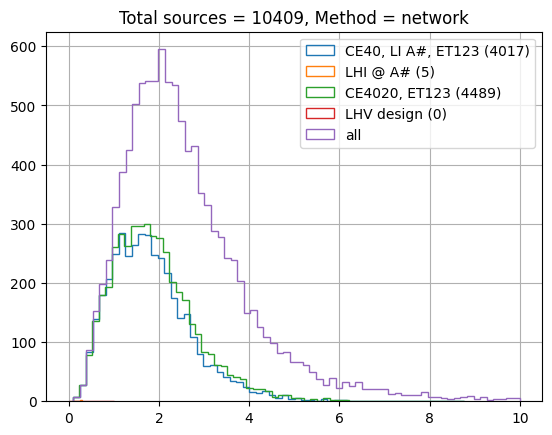

In [47]:
for key in detected_bns['network'].keys():
    bns_data = detected_bns['network'][key]
    plt.hist(bns_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bns_data["redshift"])})', bins='auto')
plt.hist(snr_data_bns['CE4020ET123']['redshift'], histtype=u'step', bins='auto', label='all')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bns["CE40LIAsharpET123"]["mass1"])}, Method = network')
plt.grid()

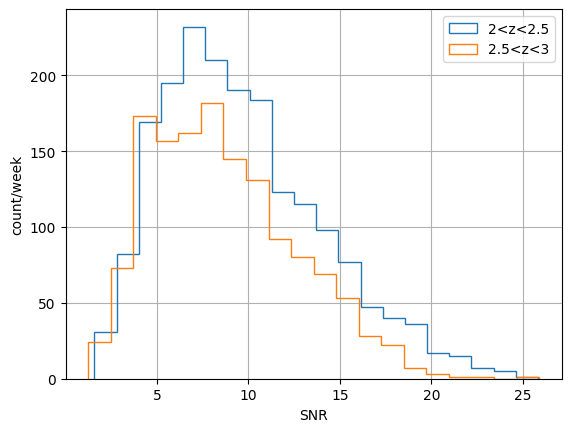

In [49]:
plt.hist(snr_data_bns['CE4020ET123']['SNR_network'][np.all((snr_data_bns['CE4020ET123']['redshift'] < 2.5, 
                                                                      snr_data_bns['CE4020ET123']['redshift'] > 2), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2<z<2.5');
plt.hist(snr_data_bns['CE4020ET123']['SNR_network'][np.all((snr_data_bns['CE4020ET123']['redshift'] < 3, 
                                                                      snr_data_bns['CE4020ET123']['redshift'] > 2.5), 
                                                                                 axis=0)], bins=20, histtype=u'step', label='2.5<z<3');
plt.xlabel('SNR')
plt.grid()
plt.ylabel('count/week')
plt.legend()
#plt.title('30 < M < 70')

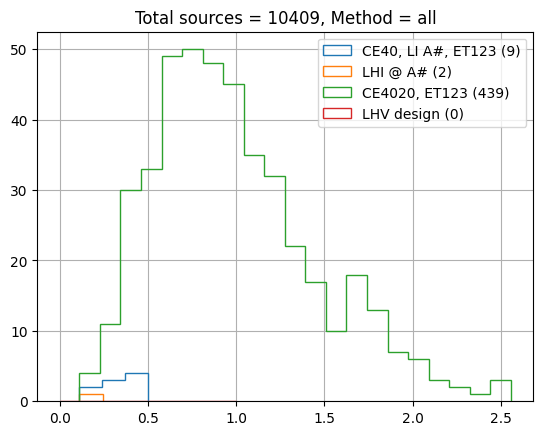

In [330]:
for key in detected_bns['all'].keys():
    bns_data = detected_bns['all'][key]
    plt.hist(bns_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bns_data["redshift"])})', bins='sqrt')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bns["CE40LIAsharpET123"]["mass1"])}, Method = all')
plt.grid()

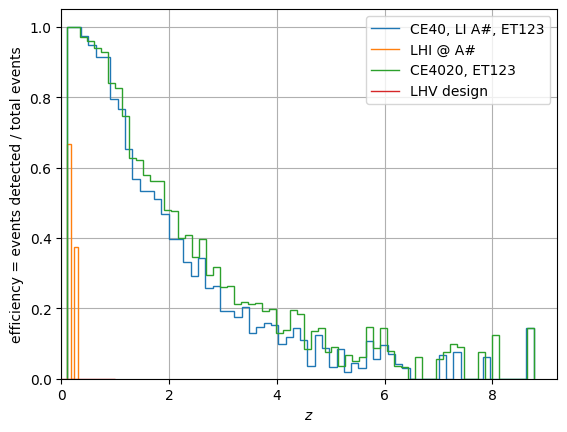

In [331]:
for netw in snr_data_bns.keys():
    vals = plot_efficiency_curve(detected_bns['network'][netw]['redshift'], snr_data_bns[netw]['redshift'], label=netw_labels[netw], zorder=2)
plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$')
plt.ylabel('efficiency = events detected / total events')
plt.grid()

### Efficiency curves comparison

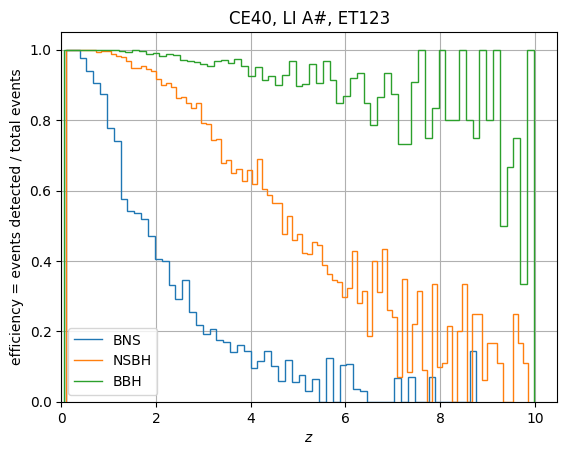

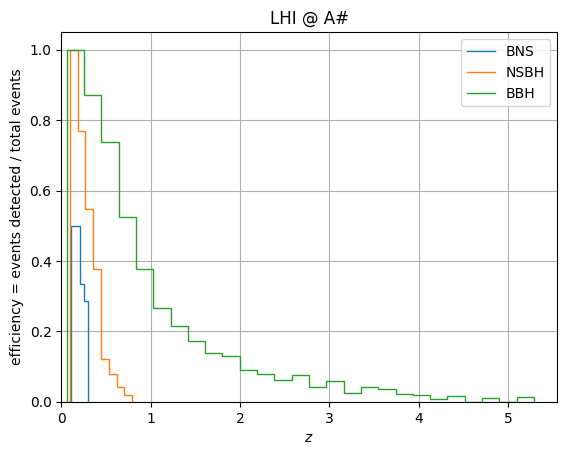

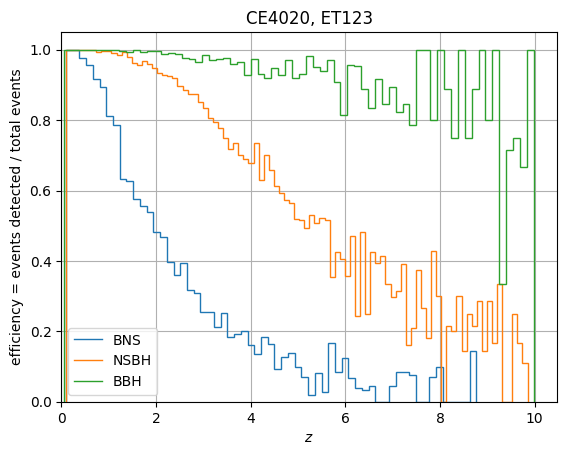

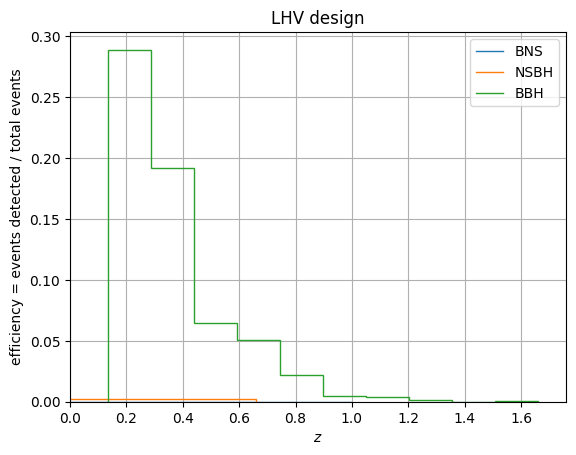

In [334]:
for netw in snr_data_bns.keys():
    plt.figure()
    for det_data, total_data, label in zip([detected_bns, detected_nsbh, detected_bbh], [snr_data_bns, snr_data_nsbh, snr_data_bbh], ['BNS', 'NSBH', 'BBH']):
        plot_efficiency_curve(det_data['network'][netw]['redshift'], 
                              total_data[netw]['redshift'], bins='auto', label=label, zorder=2)
    plt.legend()
    plt.xlim(0,)
    plt.grid()
    plt.xlabel('$z$')
    plt.ylabel('efficiency = events detected / total events')
    plt.title(netw_labels[netw])

/tmp/ipykernel_12330/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


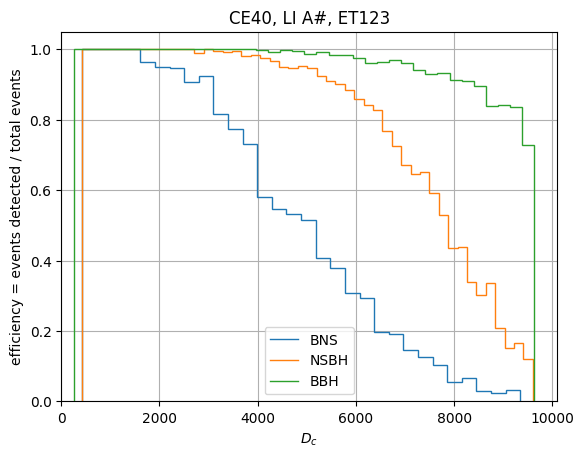

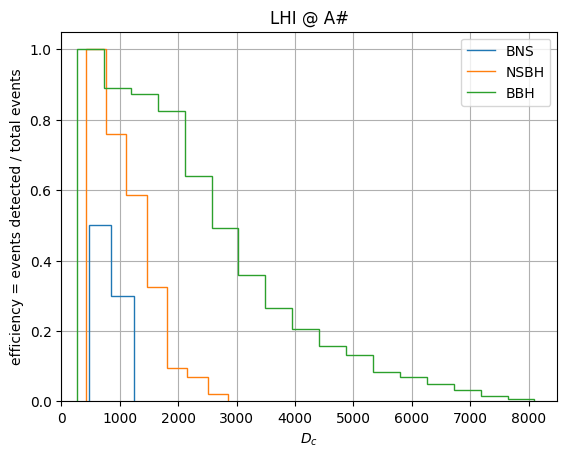

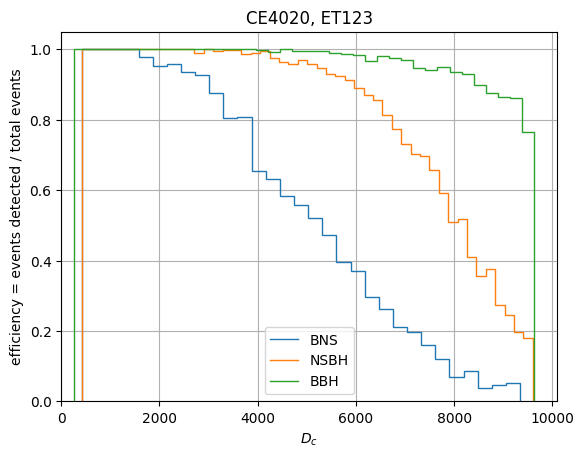

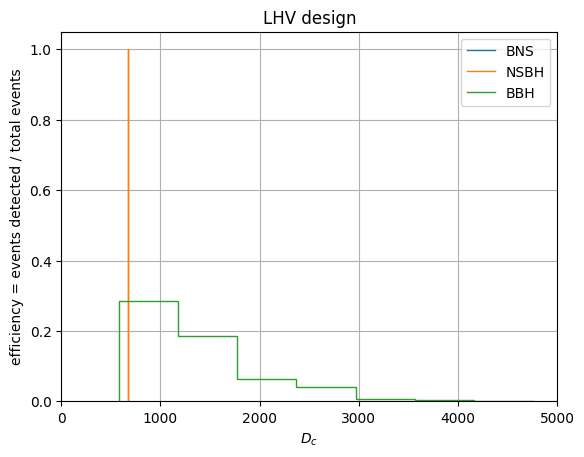

In [338]:
for netw in snr_data_bns.keys():
    plt.figure()
    for det_data, total_data, label in zip([detected_bns, detected_nsbh, detected_bbh], [snr_data_bns, snr_data_nsbh, snr_data_bbh], ['BNS', 'NSBH', 'BBH']):
        plot_efficiency_curve(det_data['network'][netw]['comoving_distance'], 
                              total_data[netw]['comoving_distance'], bins='scott', label=label, zorder=2)
    plt.legend()
    plt.xlim(0,)
    plt.grid()
    plt.xlabel('$D_c$')
    plt.ylabel('efficiency = events detected / total events')
    plt.title(netw_labels[netw])

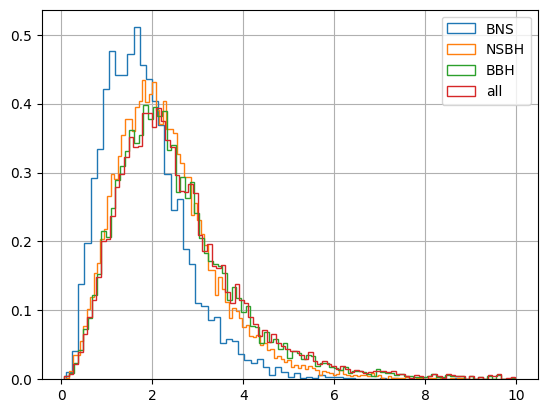

In [312]:
plt.hist(detected_bns['network']['CE40LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='BNS');
plt.hist(detected_nsbh['network']['CE40LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='NSBH');
plt.hist(detected_bbh['network']['CE40LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='BBH');
plt.hist(snr_data_bbh['CE40LIAsharpET123']['redshift'], histtype=u'step', bins='sqrt', density=True, label='all');
plt.grid()
plt.legend()